In [1]:
import sys
sys.path.append('..')

import numpy as np
import scipy as sp
import pandas as pd
from autograd import hessian, grad
import matplotlib.pyplot as plt

from noaa.daily import stations_info, hist_daily
from extremevalue.gpd import GPDMLE
rng = np.random.default_rng()

In [2]:
n_sample = 10000
x_data = rng.normal(0.0,scale=1.0,size=n_sample)

In [3]:
u = 2.0
x_exceed = x_data[np.where(x_data>u)]-u

In [4]:
xi, _, sigma = sp.stats.genpareto.fit(x_exceed,floc=0.0)
(xi,sigma)

(-0.15302873455186813, 0.42895907128109256)

In [5]:
gpddemo = GPDMLE(2.0)
gpddemo.fit(x_data)

In [6]:
gpddemo.get_params(include_ci=True)

({'xi': -0.15295554038224737, 'sigma': 0.428874831280608},
 {'xi': (-0.276529919333662, -0.02938116143083276),
  'sigma': (0.34984087749955295, 0.507908785061663)})

In [7]:
gpddemo.return_level(100.0)

2.2989789921967296

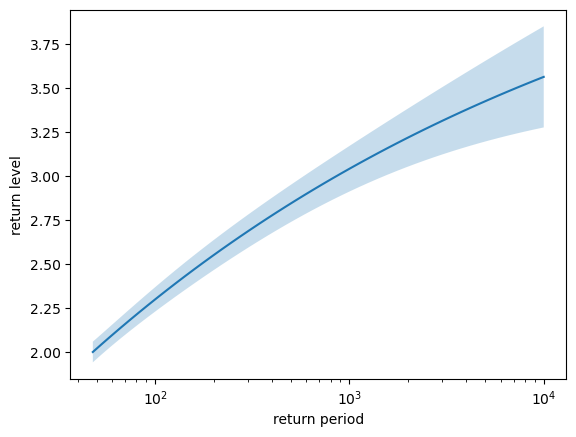

In [8]:
gpddemo.return_level_plot(include_ci=True)

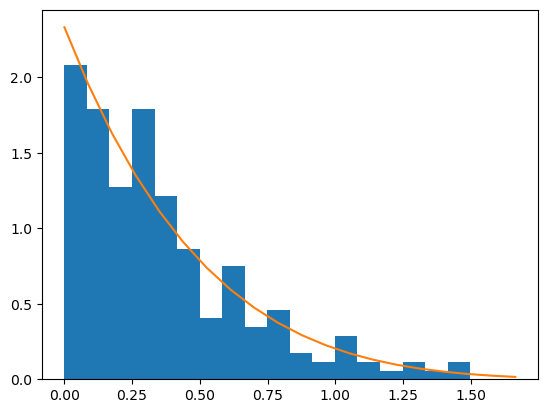

In [9]:
gpddemo.dist_plot()